<a href="https://colab.research.google.com/github/BatalovaEvgeniya/HSE_ML_2018-2019/blob/master/Linear_Regression_TF_Batalova_17112020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание

Будет две части домашнего задания.

1. Реализовать линейную регрессию на "низком уровне" в tensorflow. Обучить модель.
2. Улучшить слой keras API `Linear` так, чтобы линейная регрессия начала включать сдвиг (bias). Обучить и сравнить реузльтаты с моделью из прошлого задания. 

**Основная часть** инструкций и объяснений дана в ячейках рядом с частями задания. Если после прочтения инструкции или непонятно, как подступиться к задаче, напишите в слак Mikhail Stepanov.

Задания 1 и 2 можно выполнять в любом порядке, но внутри задания лучше идти в порядке "сверху вниз".


# 1. Линейная регрессия

Дополните существующий код так, чтобы он соотвествовал модели для линейной регрессии с использованием сдвига (bias)

Скачайте датасет [отсюда](https://www.kaggle.com/aungpyaeap/fish-market) или из личного кабинета. 

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd gdrive/My\ Drive/'OTUS. DL Basic'/HW_3

Mounted at /content/gdrive
/content/gdrive/My Drive/OTUS. DL Basic/HW_3


In [2]:
import pandas as pd
dataset = pd.read_csv('Fish.csv')

In [3]:
dataset.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


Поскольку мы будем выполнять регрессию, а не классификацию, то уберем из датасета данные о виде рыбы. Будем решать задачу по определению веса (Колонка `Weight`) по остальным параметрам (кроме `Species`).

> Вы можете попробовать закодировать данные из столбца `Species` и использовать их для регрессии. Но поскольку мы с вами не разбирали эту тему, действуйте осторожно и начните с модели, не использующей эти данные, если решите пробовать.

In [4]:
y = dataset['Weight'].values
x = dataset[['Length1',	'Length2', 'Length3',	'Height',	'Width']].values

### Подготовьте данные

> Лучше нормализовать данные, чтобы модель была более численно стабильной


In [5]:
x = (x - x.mean()) / x.std()
y = (y - y.mean()) / y.std()

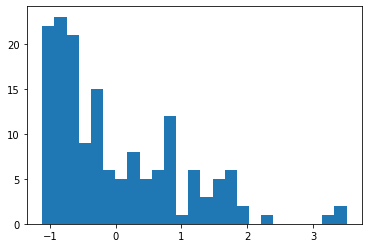

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(y, bins=25);

### Разделите данные

Данные нужно разделить в отношении 80/20 на обучающую и валидационную выборки. Кросс-валидация, регуляризация вне темы данного занятия, поэтому не будем сосредотачиваться на этом вопросе.

In [7]:
import numpy as np
np.random.seed(42)

In [8]:
pivot = int(len(y) * 0.8)
index = np.arange(len(dataset))
np.random.shuffle(index)

train_index, val_index = index[:pivot], index[pivot:]

y_train, y_val = y[train_index], y[val_index]
x_train, x_val = x[train_index], x[val_index]

In [9]:
import tensorflow as tf

### Инициализация

Воспользуйтесь x.shape, чтобы задать правильную размерность вектора с параметрами. Проинициализируйте его случайными значеними.

**Значение сдвига** `b = 0`; часто сдвиг или вектор сдвигов инициализируют нулями или средним по выборке значением, если оно отлично от нуля.

In [10]:
x.shape[1:]

(5,)

In [11]:
initial_value = tf.random.normal(shape=(x.shape[1], 1))
w = initial_value 
b = tf.Variable(0, dtype=tf.float32)
learning_rate = tf.constant(1e-4)

> Следующая функция описывает цикл обучения. Она работает корректно, в ней не обязательно что-то менять (но можно, если вам хочется).

In [12]:
def fit(x, y, threshold=0.001, n_steps=10000):
  x = tf.constant(x, dtype=tf.float32)
  y = tf.constant(y, dtype=tf.float32)
  w = tf.random.normal(shape=(x.shape[1], 1))
  b = tf.Variable(0, dtype=tf.float32)

 # print('before loop')
  for step in range(n_steps):
  #  print('#:', step)
    loss, w, b = train_step(w, x, y, b)
    if loss < threshold:
      break
    if (step + 1) % 50 == 0:
      print(f"Loss at {step} iter. is {loss.numpy()}")
  #print(loss)
  #print(w, b)      
  return loss, w, b

### Train step

Дополните `train_step` так, чтобы функция вычисляла значение $\hat{y}$ для переданного $x$, и затем значение функции ошибки с помощью функции `calc_loss`.

Добавитье обновление параметров в строчке `w = ...`. *Если возвращаемое значение* функции ошибки равно `nan` или `inf`, подумайте, что могло привести к такой ситуации и что нужно исправить.

In [13]:
def train_step(w, x, y, b):
  w = tf.Variable(w, dtype=tf.float32)
  b = tf.Variable(b, dtype=tf.float32)
  with tf.GradientTape() as tape:
    y_hat = tf.tensordot(x, w, 1) + b #model(w, x, b)
    loss = calc_loss(y, y_hat)
    dw, db= tape.gradient(loss, [w, b])
 # print(dw)
  #print(db)
  w = tf.subtract(w, learning_rate*dw)
  b = tf.subtract(b, learning_rate*db)
 # print(w, b)
  return loss, w, b

Умножение вектора на вектор или вектора на строку в `tf` - это сложная операция. В отличие от матричного умножения, которое можно записать просто как `C = A @ B` или `C = tf.matmul(A, B)`, здесь нужно вызывать функцию `tf.tensordot`, которая способна умножать тензоры любой размерности. Затем функции надо указать ось, по которой выполняется сложение: в данном случае, 1 - т.е. для произведения матрицы на вектор нужно выполнить операцию

`tf.tensordot(x, w, 1)`

Воспользовавшись этим способом, напишите модель для линейной регрессии. Кстати, это не единственный возможный вариант [расчета скалярного произведения в tensorflow](https://stackoverflow.com/questions/40670370/dot-product-of-two-vectors-in-tensorflow).

In [14]:
def model(w, x, b):
  return   tf.tensordot(tf.constant(x, dtype=tf.float32), w, 1) + b
  

Напишите функцию, которая вычисляет значение MSE для двух переданных векторов со значениями $y, \hat{y}$ (истинные и спрогнозированные значения). Функция должна возвращать _одно_ значение (скаляр), как и в формуле $\frac{1}{n}\sum_{i=1}^{n}(y^{(i)} - \hat{y}^{(i)})^2$ 

* разность векторов и возведение в квадрат можно сделать при помощи обычных операторов `-`, `**2`
* Для того, чтобы в тензорфлоу выполнить аналог операции $\frac{1}{n}\sum_{i=1}^n (...)$, воспользуйтесь функцией `tf.reduce_mean`. Заодно можете изучить, какие еще есть `tf.reduce_...` функции :)

In [15]:
def calc_loss(y, y_hat):
  return tf.reduce_mean(tf.square(y - y_hat))

### Обучение

> Обучите модель

In [16]:
loss_, w_, b_ = fit(x_train, y_train)

Loss at 49 iter. is 3.4245669841766357
Loss at 99 iter. is 3.251248836517334
Loss at 149 iter. is 3.093258857727051
Loss at 199 iter. is 2.9491913318634033
Loss at 249 iter. is 2.8177683353424072
Loss at 299 iter. is 2.697833299636841
Loss at 349 iter. is 2.5883350372314453
Loss at 399 iter. is 2.4883203506469727
Loss at 449 iter. is 2.3969223499298096
Loss at 499 iter. is 2.313359022140503
Loss at 549 iter. is 2.2369160652160645
Loss at 599 iter. is 2.16694712638855
Loss at 649 iter. is 2.1028668880462646
Loss at 699 iter. is 2.0441431999206543
Loss at 749 iter. is 1.9902924299240112
Loss at 799 iter. is 1.9408761262893677
Loss at 849 iter. is 1.8954966068267822
Loss at 899 iter. is 1.8537930250167847
Loss at 949 iter. is 1.8154369592666626
Loss at 999 iter. is 1.7801318168640137
Loss at 1049 iter. is 1.7476047277450562
Loss at 1099 iter. is 1.7176116704940796
Loss at 1149 iter. is 1.6899303197860718
Loss at 1199 iter. is 1.6643569469451904
Loss at 1249 iter. is 1.6407074928283691
Los

### Напишите функцию для оцени качества модели

Функция должна принимать на вход данные и значение целевой переменной возвращать значение ошибки (скаляр). Сравните ошибку на обучающей и валидационной выборке, сделайте выводы о том, переобучена ли модель.

In [17]:
def evaluate(x, y, w, b):
  y_hat = model(w, x, b)
  return calc_loss(y,y_hat)

In [18]:
evaluate(x_val, y_val, w ,b)

<tf.Tensor: shape=(), dtype=float32, numpy=14.725935>

# 2. Слой Linear

* Дополните линейный слой так, чтобы у него появились веса для сдвига. Для этого используйте метод `add_weight`. Размерность вектора с весами для сдвига равно размерности слоя на выходе (параметр `units`). 
* Для инициализации сдвига _нулями_ передайте `tf.keras.initializers.Zeros()` в качестве значения для параметра `add_weight(..., initializer=...)` 
* Измените метод `call` так, чтобы он использовал сдвиги.
* Обучите модель на тех же данных, что и в первом задании.

In [97]:
class Linear(tf.keras.layers.Layer):
  def __init__(self, units, initializer='glorot_uniform', **kwargs):
    super().__init__(**kwargs)
    self.units = units
    self.initializer = keras.initializers.get(initializer)

  def build(self, input_shape):
    print('build')
    self.kernel = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer=self.initializer,
            name="kernel",
            trainable=True
        )
    self.bias = self.add_weight(
            shape=(self.units),
            initializer=self.initializer,
            name='bias',
            trainable=True
         )

  def call(self, inputs):
    return tf.matmul(inputs, self.kernel) + self.bias
    
  def get_config(self):
    base_config = super(Linear, self).get_config()
    config = {"initializer": keras.initializers.serialize(self.initializer)}
    return dict(list(base_config.items()) + list(config.items()))

## Запустите модель и сравните результаты с моделью из п.1

In [100]:
!pwd

/content/gdrive/My Drive/OTUS. DL Basic/HW_3


In [101]:
import tensorflow.keras as keras
import os
import datetime


logdir = os.path.join("/content/gdrive/My Drive/OTUS. DL Basic/HW_3", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = keras.callbacks.TensorBoard(logdir, histogram_freq=1)

linear_layer = Linear(1)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               min_delta=1e-4)
model = keras.models.Sequential([linear_layer])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
              loss='mse')

> **Обратите внимание**, что добавился параметр `validation_data`, а в `EarlyStopping` в ячейке выше значение параметра `monitor` заменено на `val_loss`!

In [102]:
history = model.fit(x_train, np.expand_dims(y_train, axis=-1), 
                    validation_data=(x_val, y_val),
                    batch_size=512,
                    epochs=100,
                    callbacks=[early_stopping, tensorboard],
                    verbose=1)

Epoch 1/100
build
build


TypeError: ignored

## Tensorboard
> Выведите полученные результаты в tensorboard. Это сервис, который позволяет визуализировать процесс обучения модели, состояние графа и не только. 

Для запуска нужно 
* Установить расширение
* Выполнить команду запуска, передав ей имя директории, в которую записывал логи `callbacks.Tensorboard`.

Более подробно изучим tensorboard на будущих занятиях. Пока можете посмотреть вкладки scalars, graphs, distributions, histograms. В них содержится информация о метриках модели, графе, распередлениях и гистограммах параметров.

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs